<a href="https://colab.research.google.com/github/tmonreal/Chest-X-ray-Medical-Diagnosis-with-Deep-Learning/blob/main/Chest_X_ray_Medical_Diagnosis_with_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chest X-ray Medical Diagnosis with Deep Learning

This project has been created by Trinidad Monreal for the course "*AI for Medical Diagnosis*" by DeepLearning.ai.


## Introduction

Computer Vision (CV) has lots of applications in medical diagnosis, including among others: dermatology, ophthakmology and histopathology. 

X-ray images result critical for the detection of lung cancer and pneumonia.

In this notebook, I will set-up a pre-trained neural network to make disease predictions on chest X-rays. The images will be taken from the public [ChestX-ray8 dataset](https://arxiv.org/abs/1705.02315).

### Import Packages and Functions

In [32]:
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import ( Dense, Conv2D, MaxPool2D, Dropout, Flatten, 
                           BatchNormalization, GlobalAveragePooling2D
                         )

from keras.applications.densenet import DenseNet121
from keras import backend as K

from sklearn.metrics import confusion_matrix, classification_report

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Accessing the dataset directory mounted in my google drive
os.listdir("/content/drive/MyDrive/chest_xray")

['.DS_Store', 'train', 'val', 'test']

## Data Visualization

The dataset is divided into three sets:

1. Train set
2. Validation set and
3. Test set.

Each of the sets has two types of images: 'NORMAL' (for healthy patients) or 'PNEUMONIA' (for patients with pneumonia)

In [4]:
# Accessing the train, test and validation directories
train_dir = "/content/drive/MyDrive/chest_xray/train"
test_dir = "/content/drive/MyDrive/chest_xray/test"
val_dir = "/content/drive/MyDrive/chest_xray/val"

# Accessing the pneumonia and normal directories for each set
print("Train set:\n========================================")
num_pneumonia = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
num_normal = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
print(f"PNEUMONIA={num_pneumonia}")
print(f"NORMAL={num_normal}")

print("Test set:\n========================================")
print(f"PNEUMONIA = {len(os.listdir(os.path.join(test_dir, 'PNEUMONIA')))}")
print(f"NORMAL = {len(os.listdir(os.path.join(test_dir, 'NORMAL')))}")

print("Validation set:\n========================================")
print(f"PNEUMONIA = {len(os.listdir(os.path.join(val_dir, 'PNEUMONIA')))}")
print(f"NORMAL = {len(os.listdir(os.path.join(val_dir, 'NORMAL')))}")

Train set:
PNEUMONIA=3875
NORMAL=1341
Test set:
PNEUMONIA = 390
NORMAL = 234
Validation set:
PNEUMONIA = 8
NORMAL = 8


Text(0.5, 0.98, 'Raw "PNEUMONIA" Chest X-Ray Train Images')

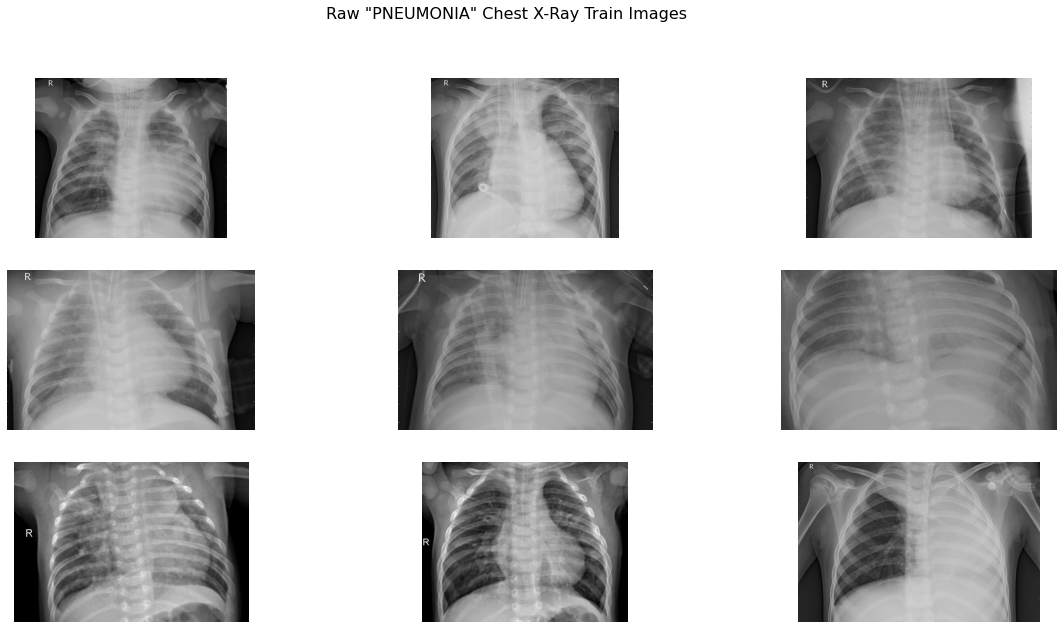

In [5]:
# Accessing pneumonia directory
pneumonia_dir = "/content/drive/MyDrive/chest_xray/train/PNEUMONIA"
pneumonia = os.listdir(pneumonia_dir)

# Plotting pneumonia images 
fig = plt.figure(figsize=(20, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(pneumonia_dir, pneumonia[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
fig.suptitle('Raw "PNEUMONIA" Chest X-Ray Train Images', fontsize=16)

Text(0.5, 0.98, 'Raw "NORMAL" Chest X-Ray Train Images')

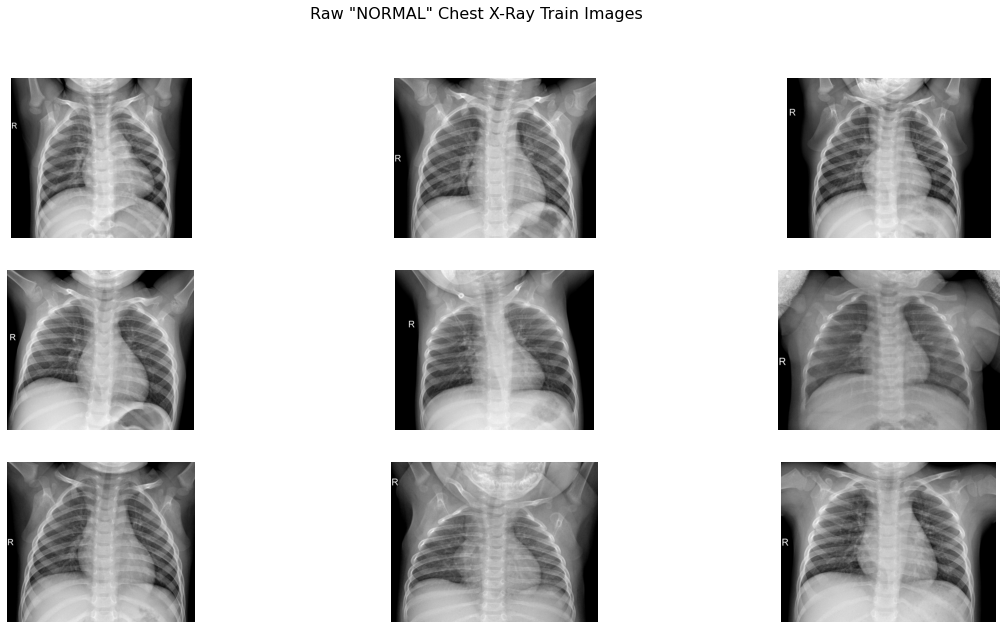

In [6]:
# Accessing normal directory
normal_dir = "/content/drive/MyDrive/chest_xray/train/NORMAL"
normal = os.listdir(normal_dir)

# Plotting normal images
fig = plt.figure(figsize=(20, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(normal_dir, normal[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')

fig.suptitle('Raw "NORMAL" Chest X-Ray Train Images', fontsize=16)

#### Investigating a single image

The dimensions of the image are: (1395, 1576) pixels, one single color channel.
The maximum pixel value is 255 and the minimum is 0
The mean value of the pixels is 118.4272 and the standard deviation is 69.4731


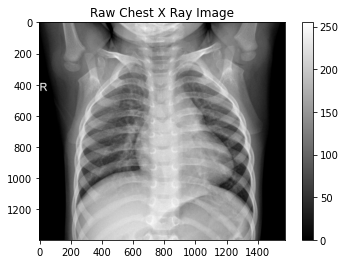

In [7]:
# Accesing first image in normal 
normal_img = os.listdir(normal_dir)[0]

sample_img = plt.imread(os.path.join(normal_dir, normal_img))
plt.imshow(sample_img, cmap='gray')
plt.colorbar()
plt.title('Raw Chest X Ray Image')

print(f"The dimensions of the image are: ({sample_img.shape[0]}, {sample_img.shape[1]}) pixels, one single color channel.")
print(f"The maximum pixel value is {sample_img.max()} and the minimum is {sample_img.min()}")
print(f"The mean value of the pixels is {sample_img.mean():.4f} and the standard deviation is {sample_img.std():.4f}")

 #### Investigate pixel value distribution

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, '# Pixels in Image')

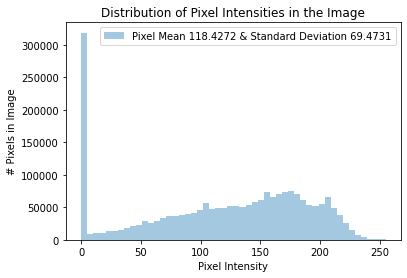

In [8]:
sns.distplot(sample_img.ravel(),
             label=f"Pixel Mean {np.mean(sample_img):.4f} & Standard Deviation {np.std(sample_img):.4f}", 
             kde=False)
plt.legend(loc='upper right')
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixels in Image')

 ## Image Preprocessing

Before training, I'll first modify the images to be better suited for training a convolutional neural network. For this task, I'll be using the Keras `ImageDataGenerator` function to perform data preprocessing and **data augmentation**.

- This class provides support for basic data augmentation, such as random horizontal flipping of images.

- I also use the generator to transform the values in each batch so that their mean is 0 and their standard deviation is 1 (this will facilitate model training by standardizing the input distribution).

- The generator also converts our single-channel X-ray images (gray-scale) to a three-channel format by repeating the values in the image across all channels (this is necessary since the pre-trained model that I'll use requires three-channel inputs).

In [9]:
# Image generator for training set
image_generator = ImageDataGenerator(rotation_range=20,
                                      width_shift_range=0.1,
                                      shear_range=0.1,
                                      zoom_range=0.1,
                                      samplewise_center=True,
                                      samplewise_std_normalization=True
)

- Now we need to build a new generator for validation and testing data. 
- The main reason why I am not using the same generator for these sets is to avoid using batch statistics. 
  - It is okay to normalize each image per batch for the training set. However, this should not be dones with the test and validation data, since in a real-life scenario we don't process incoming images a batch at a time (we process one image at a time). 
- Knowing the average per batch of test data would effectively give our model an advantage (The model should not have any information about the test data).
- For this reason, I will normalize incoming test data using the statistics computed from the training set.

In [10]:
train = image_generator.flow_from_directory(train_dir, 
                                            batch_size=8, 
                                            shuffle=True, 
                                            class_mode='binary',
                                            target_size=(320, 320))

validation = image_generator.flow_from_directory(val_dir, 
                                                batch_size=1, 
                                                shuffle=False, 
                                                class_mode='binary',
                                                target_size=(320, 320))

test = image_generator.flow_from_directory(test_dir, 
                                            batch_size=1, 
                                            shuffle=False, 
                                            class_mode='binary',
                                            target_size=(320, 320))

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


#### Investigating a single generated image

The dimensions of the image are (320, 320) pixels, one single color channel.
The maximum pixel value is 2.6599 and the minimum is -2.3254
The mean value of the pixels is 0.0 and the standard deviation is 1.0


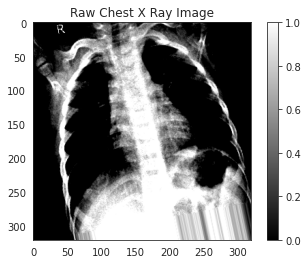

In [11]:
# Plotting a generated image
sns.set_style('white')
generated_image, label = train.__getitem__(0)
plt.imshow(generated_image[0], cmap='gray')
plt.colorbar()
plt.title('Raw Chest X Ray Image')

print(f"The dimensions of the image are ({generated_image.shape[1]}, {generated_image.shape[2]}) pixels, one single color channel.")
print(f"The maximum pixel value is {generated_image.max():.4f} and the minimum is {generated_image.min():.4f}")
print(f"The mean value of the pixels is {generated_image.mean():.1f} and the standard deviation is {generated_image.std():.1f}")

#### Investigate pixel value distribution

Text(0, 0.5, '# Pixels in Image')

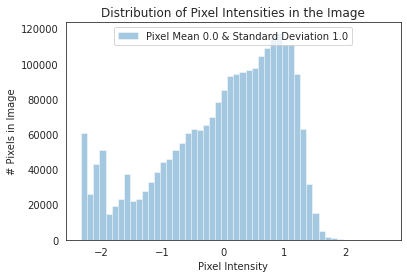

In [12]:
sns.distplot(generated_image.ravel(),
             label=f"Pixel Mean {np.mean(generated_image):.1f} & Standard Deviation {np.std(generated_image):.1f}", 
             kde=False)
plt.legend(loc='upper center')
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixels in Image')

## Model Building

One of the challenges with working with medical diagnostic datasets is the large class imbalance present in such datasets.

### Impact of imbalance data on loss function

Loss Function:

$$
\mathcal{L}_{cross-entropy}(x_i) = -(y_i \log(f(x_i)) + (1-y_i) \log(1-f(x_i)))
$$

We can rewrite the the overall average cross-entropy loss over the entire training set D of size N as follows:

$$
\mathcal{L}_{cross-entropy}(\mathcal{D}) = - \frac{1}{N}\big( \sum_{\text{positive examples}} \log (f(x_i)) + \sum_{\text{negative examples}} \log(1-f(x_i)) \big).
$$

When we have an imbalance data, using a normal loss function will result a model that bias toward the dominating class. One solution is to use a weighted loss function. Using weighted loss function will balance the contribution in the loss function.

$$
\mathcal{L}_{cross-entropy}^{w}(x) = - (w_{p} y \log(f(x)) + w_{n}(1-y) \log( 1 - f(x) ) ).
$$



In [13]:
# Class weights

weight_for_0 = num_pneumonia / (num_normal + num_pneumonia)
weight_for_1 = num_normal / (num_normal + num_pneumonia)

class_weight = {0: weight_for_0, 1: weight_for_1}

print(f"Weight for class 0: {weight_for_0:.2f}")
print(f"Weight for class 1: {weight_for_1:.2f}")

Weight for class 0: 0.74
Weight for class 1: 0.26


In [14]:
# Creating CNN
model = Sequential()

# Convolution Layer with 32 filters and ReLU activation function
model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(320, 320, 3), activation='relu'))
model.add(BatchNormalization())
# Convolution Layer with 32 filters and ReLU activation function
model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(320, 320, 3), activation='relu'))
model.add(BatchNormalization())
# Max Pooling Layer 2x2
model.add(MaxPool2D(pool_size=(2, 2)))

# Convolution Layer with 64 filters and ReLU activation function
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
# Convolution Layer with 64 filters and ReLU activation function
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
# Max Pooling Layer 2x2 window
model.add(MaxPool2D(pool_size=(2, 2)))

# Convolution Layer with 128 filters and ReLU activation function
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
# Convolution Layer with 128 filters and ReLU activation function
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
# Max Pooling Layer 2x2 window
model.add(MaxPool2D(pool_size=(2, 2)))

# Flatten to a vector
model.add(Flatten())
# Dense Layer with ReLU activation function
model.add(Dense(128, activation='relu'))
# Dropout Layer 
model.add(Dropout(0.2))
# Fense Layer with sigmoid activation function
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 318, 318, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 318, 318, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 316, 316, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 316, 316, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 158, 158, 32)     0         
 )                                                               
                                                        

In [19]:
r = model.fit(
    train, 
    epochs=20,
    validation_data=validation, 
    class_weight=class_weight,
    steps_per_epoch=100,
    validation_steps=25,
)

Epoch 1/20
100/100 [==============================] - ETA: 0s - loss: 0.2150 - accuracy: 0.7450

100/100 [==============================] - 62s 618ms/step - loss: 0.2150 - accuracy: 0.7450 - val_loss: 1.6750 - val_accuracy: 0.5000
Epoch 2/20
100/100 [==============================] - 59s 595ms/step - loss: 0.1755 - accuracy: 0.7638
Epoch 3/20
100/100 [==============================] - 47s 464ms/step - loss: 0.1162 - accuracy: 0.7962
Epoch 4/20
100/100 [==============================] - 47s 467ms/step - loss: 0.1293 - accuracy: 0.7163
Epoch 5/20
100/100 [==============================] - 43s 430ms/step - loss: 0.1312 - accuracy: 0.7837
Epoch 6/20
100/100 [==============================] - 42s 418ms/step - loss: 0.1675 - accuracy: 0.7163
Epoch 7/20
100/100 [==============================] - 40s 395ms/step - loss: 0.2067 - accuracy: 0.7337
Epoch 8/20
100/100 [==============================] - 38s 379ms/step - loss: 0.1726 - accuracy: 0.6975
Epoch 9/20
100/100 [==============================] - 39s 385ms/step - loss: 0.1566 - accuracy: 0.7462
Epoch 10/20
100/100 [=====================

Text(0.5, 1.0, 'Accuracy Evolution')

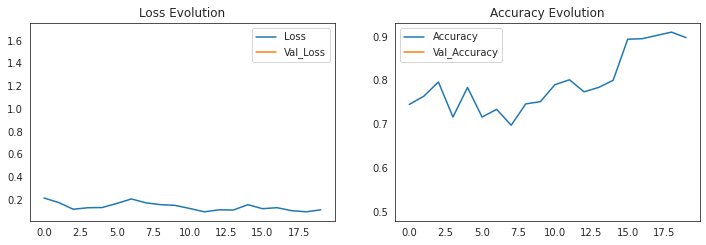

In [20]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(r.history['accuracy'], label='Accuracy')
plt.plot(r.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

#### Model Evaluation

In [21]:
# Accuracy
evaluation = model.evaluate(test)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = model.evaluate(train)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

624/624 [==============================] - 114s 184ms/step - loss: 0.7457 - accuracy: 0.7372
Test Accuracy: 73.72%
652/652 [==============================] - 214s 327ms/step - loss: 0.1919 - accuracy: 0.9339
Train Accuracy: 93.39%


In [22]:
# Confussion Matrix
pred = model.predict(test)

print(confusion_matrix(test.classes, pred > 0.5))
pd.DataFrame(classification_report(test.classes, pred > 0.5, output_dict=True))

624/624 [==============================] - 28s 45ms/step
[[ 77 157]
 [  4 386]]


,0,1,accuracy,macro avg,weighted avg
precision,0.950617,0.710866,0.741987,0.830741,0.800772
recall,0.329060,0.989744,0.741987,0.659402,0.741987
f1-score,0.488889,0.827438,0.741987,0.658164,0.700482
support,234.000000,390.000000,0.741987,624.000000,624.000000


In [23]:
print(confusion_matrix(test.classes, pred > 0.7))
pd.DataFrame(classification_report(test.classes, pred > 0.7, output_dict=True))

[[143  91]
 [ 13 377]]


,0,1,accuracy,macro avg,weighted avg
precision,0.916667,0.805556,0.833333,0.861111,0.847222
recall,0.611111,0.966667,0.833333,0.788889,0.833333
f1-score,0.733333,0.878788,0.833333,0.806061,0.824242
support,234.000000,390.000000,0.833333,624.000000,624.000000


### DenseNet

Densenet is a convolutional network where each layer is connected to all other layers that are deeper in the network:

- The first layer is connected to the 2nd, 3rd, 4th etc.
- The second layer is conected to the 3rd, 4th, 5th etc.

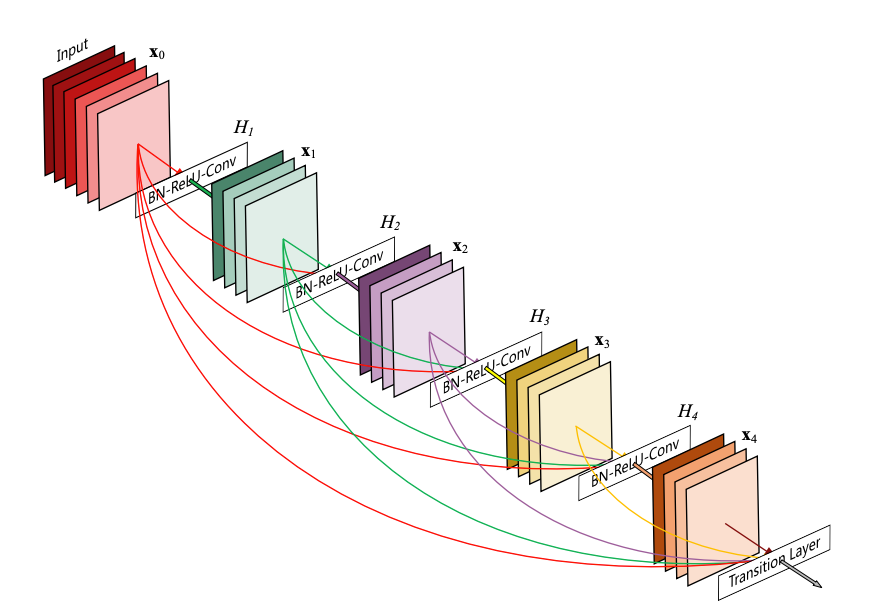

In [24]:
# DenseNet
base_model = DenseNet121(input_shape=(320, 320, 3), include_top=False, weights='imagenet', pooling='avg')

base_model.summary()

29084464/29084464 [==============================] - 0s 0us/step
Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 320, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 326, 326, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 160, 160, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                       

In [25]:
layers = base_model.layers
print(f"The model has {len(layers)} layers")

print(f"The input shape {base_model.input}")
print(f"The output shape {base_model.output}")

The model has 428 layers
The input shape KerasTensor(type_spec=TensorSpec(shape=(None, 320, 320, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
The output shape KerasTensor(type_spec=TensorSpec(shape=(None, 1024), dtype=tf.float32, name=None), name='avg_pool/Mean:0', description="created by layer 'avg_pool'")


In [26]:
base_model = DenseNet121(include_top=False, weights='imagenet')
x = base_model.output
x = GlobalAveragePooling2D()(x)

predictions = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

r = model.fit(
    train, 
    epochs=10,
    validation_data=validation,
    class_weight=class_weight,
    steps_per_epoch=100,
    validation_steps=25,
)

Epoch 1/10
100/100 [==============================] - ETA: 0s - loss: 0.1533 - accuracy: 0.8438

100/100 [==============================] - 128s 441ms/step - loss: 0.1533 - accuracy: 0.8438 - val_loss: 44.0015 - val_accuracy: 0.5000
Epoch 2/10
100/100 [==============================] - 41s 405ms/step - loss: 0.1185 - accuracy: 0.8675
Epoch 3/10
100/100 [==============================] - 40s 400ms/step - loss: 0.1000 - accuracy: 0.9013
Epoch 4/10
100/100 [==============================] - 41s 410ms/step - loss: 0.1000 - accuracy: 0.9038
Epoch 5/10
100/100 [==============================] - 39s 393ms/step - loss: 0.0896 - accuracy: 0.8938
Epoch 6/10
100/100 [==============================] - 45s 454ms/step - loss: 0.0985 - accuracy: 0.9062
Epoch 7/10
100/100 [==============================] - 50s 493ms/step - loss: 0.0906 - accuracy: 0.9050
Epoch 8/10
100/100 [==============================] - 41s 411ms/step - loss: 0.0845 - accuracy: 0.8988
Epoch 9/10
100/100 [==============================] - 41s 413ms/step - loss: 0.0758 - accuracy: 0.9175
Epoch 10/10
100/100 [===================

Text(0.5, 1.0, 'Accuracy Evolution')

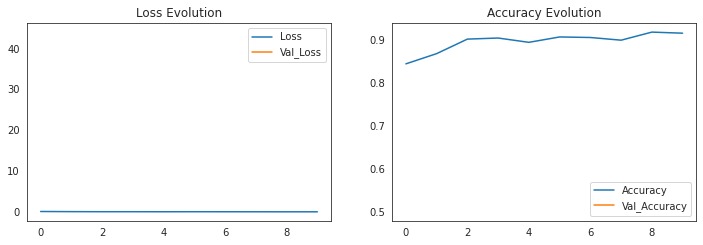

In [27]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(r.history['accuracy'], label='Accuracy')
plt.plot(r.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

#### Model Evaluation

In [28]:
evaluation = model.evaluate(test)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = model.evaluate(train)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

624/624 [==============================] - 37s 58ms/step - loss: 0.7830 - accuracy: 0.8125
Test Accuracy: 81.25%
652/652 [==============================] - 222s 340ms/step - loss: 0.8756 - accuracy: 0.8221
Train Accuracy: 82.21%


In [29]:
predicted_vals = model.predict(test, steps=len(test))

print(confusion_matrix(test.classes, predicted_vals > 0.5))
pd.DataFrame(classification_report(test.classes, predicted_vals > 0.5, output_dict=True))

624/624 [==============================] - 38s 57ms/step
[[198  36]
 [ 74 316]]


,0,1,accuracy,macro avg,weighted avg
precision,0.727941,0.897727,0.823718,0.812834,0.834057
recall,0.846154,0.810256,0.823718,0.828205,0.823718
f1-score,0.782609,0.851752,0.823718,0.817180,0.825823
support,234.000000,390.000000,0.823718,624.000000,624.000000


In [30]:
print(confusion_matrix(test.classes, predicted_vals > 0.7))
pd.DataFrame(classification_report(test.classes, predicted_vals > 0.7, output_dict=True))

[[203  31]
 [ 87 303]]


,0,1,accuracy,macro avg,weighted avg
precision,0.700000,0.907186,0.810897,0.803593,0.829491
recall,0.867521,0.776923,0.810897,0.822222,0.810897
f1-score,0.774809,0.837017,0.810897,0.805913,0.813689
support,234.000000,390.000000,0.810897,624.000000,624.000000
